In [1]:
# diffusion_utils.py
import torch
import torch.nn as nn
import numpy as np

class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.device = device
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1, 1)
        return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

    def p_losses(self, model, x_start, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        noise_pred = model(x_noisy, t)
        return nn.functional.mse_loss(noise_pred, noise)
    def sample(self, model, shape):
        x = torch.randn(shape, device=self.device)
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((x.shape[0],), t, device=self.device, dtype=torch.long)
            noise_pred = model(x, t_tensor)

            beta_t = self.betas[t]
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alpha_bars[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / alpha_t.sqrt()) * (
                x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * noise_pred
            ) + beta_t.sqrt() * noise

        return x
# model.py
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Small3DUNet(nn.Module):
    def __init__(self, in_channels=64, base_channels=64, time_emb_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, base_channels)
        )

        self.encoder = ConvBlock(in_channels, base_channels)
        self.middle  = ConvBlock(base_channels, base_channels)
        self.decoder = ConvBlock(base_channels, in_channels)
        self.final = nn.Conv3d(in_channels, in_channels, kernel_size=1)

    def forward(self, x, t):  # t: [B]
        # 把 t 变成 float 并扩展为 [B, 1]
        t = t[:, None].float() / 1000  # normalized
        t_embed = self.time_mlp(t)  # [B, base_channels]

        # reshape 成 [B, C, 1, 1, 1]，可加到特征图上
        t_embed = t_embed[:, :, None, None, None]

        skip = x
        x = self.encoder(x + t_embed)
        x = self.middle(x + t_embed)
        x = self.decoder(x + t_embed)
        x = x + skip
        return self.final(x)

# train_diffusion.py
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
# from diffusion_utils import GaussianDiffusion
# from model import Small3DUNet
from tqdm import tqdm

class LatentPatchDataset(Dataset):
    def __init__(self, latent_root):
        self.paths = list(Path(latent_root).rglob("*_rot0.pt"))

    def __len__(self):
        return len(self.paths) * 4

    def __getitem__(self, idx):
        base = self.paths[idx // 4]
        rot = idx % 4
        path = str(base).replace("_rot0", f"_rot{rot}")
        latent = torch.load(path)  # [64, 4, 3, 4]
        return latent

def train_diffusion():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Small3DUNet(in_channels=64).to(device)
    diffusion = GaussianDiffusion(timesteps=1000, device=device)
    dataset = LatentPatchDataset("latents")
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

    for epoch in range(1, 101):
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch}", dynamic_ncols=True)
        for batch in pbar:
            batch = batch.to(device)
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device).long()
            loss = diffusion.p_losses(model, batch, t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())

        torch.save(model.state_dict(), f"diffusion_epoch{epoch}.pt")

# if __name__ == "__main__":
#     train_diffusion()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
from torch.amp import autocast, GradScaler

# === 你的模型、数据集、diffusion 等需要提前定义 ===
# from your_module import Small3DUNet, GaussianDiffusion, LatentPatchDataset

def train_diffusion_with_scheduler_amp(start_epoch=11, total_epochs=20, model_path="diffusion_epoch11.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 🧠 初始化模型、diffusion、dataset、optimizer
    model = Small3DUNet(in_channels=64).to(device)
    diffusion = GaussianDiffusion(timesteps=100, device=device)
    dataset = LatentPatchDataset("latents")
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

    # ✅ 加载模型（可选）
    if model_path and Path(model_path).exists():
        print(f"📦 Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))

    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs - start_epoch, eta_min=1e-5)
    scaler = GradScaler()  # 自动混合精度 scaler

    # 🌀 开始训练
    for epoch in range(start_epoch, total_epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"🌊 Epoch {epoch}", dynamic_ncols=True)

        for batch in pbar:
            batch = batch.to(device)
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),), device=device).long()

            optimizer.zero_grad()

            with autocast(device_type="cuda"):  # 半精度训练部分
                loss = diffusion.p_losses(model, batch, t)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        scheduler.step()
        print(f"📉 Epoch {epoch} | Loss: {total_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
        torch.save(model.state_dict(), f"diffusion_epoch{epoch}.pt")

if __name__ == "__main__":
    train_diffusion_with_scheduler_amp()


📦 Loading model from diffusion_epoch11.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\603479003.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
🌊 Epoch 11:   0

KeyboardInterrupt: 

C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\2770606941.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diff_model.load_state_dict(torch.load("diffusion_epoch10.pt"

📥 Loaded model from voxelvae_64_434.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\2770606941.py:197: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20b", 31)


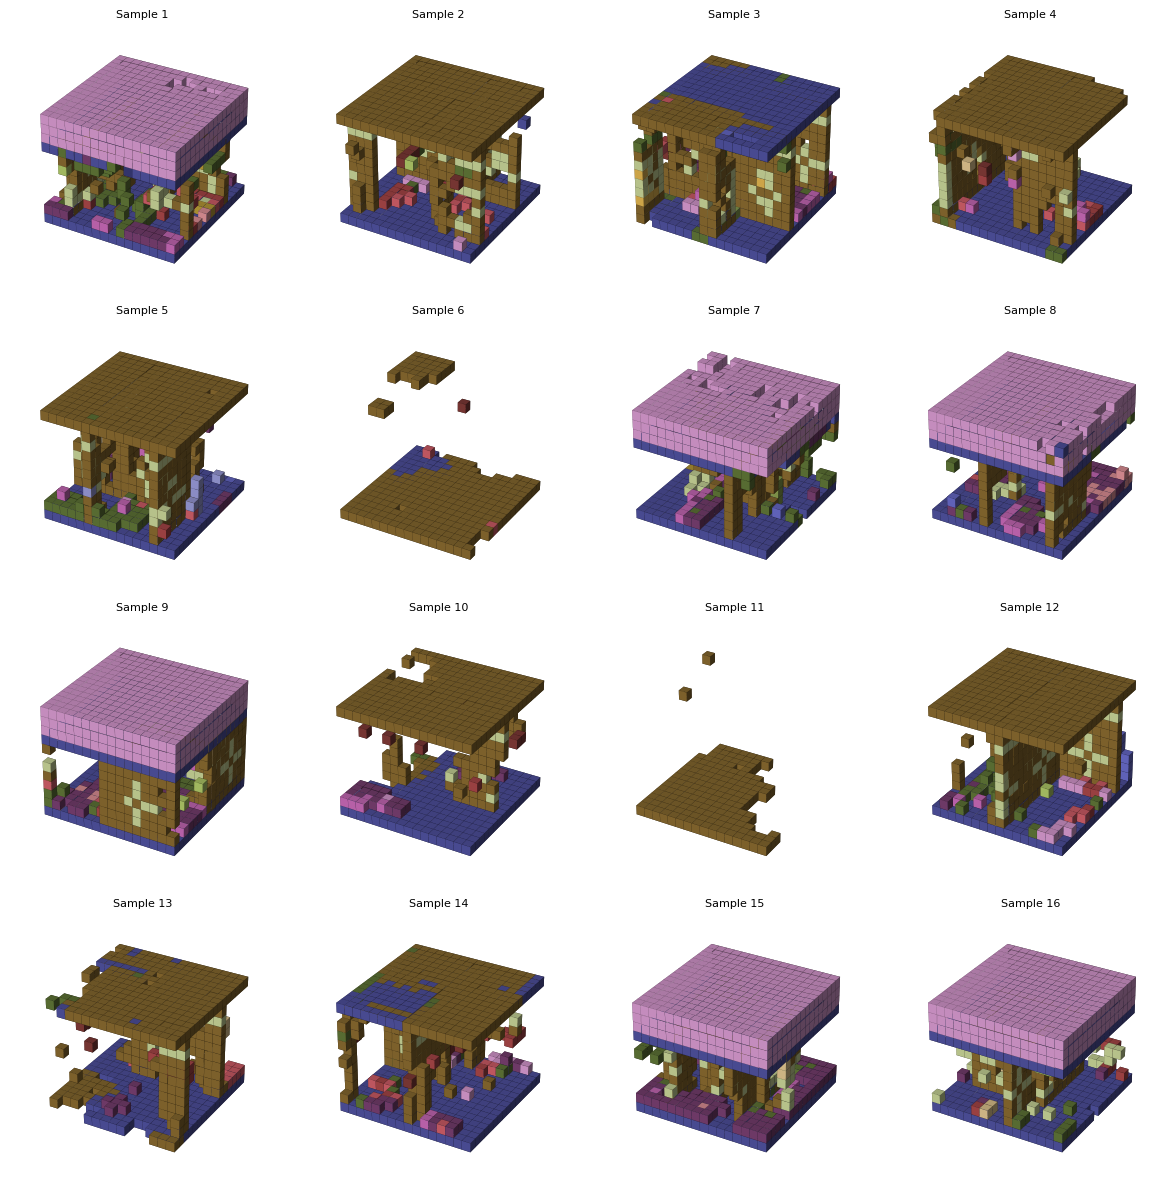

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 模型加载 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load diffusion model
diff_model = Small3DUNet(in_channels=64).to(device)
diff_model.load_state_dict(torch.load("diffusion_epoch10.pt", map_location=device))
diff_model.eval()
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------
# Encoder with VAE heads
# --------------------------
class Encoder(nn.Module):
    def __init__(self, geo_feat_channels=128, z_down=True, padding_mode="replicate", latent_dim=128, kernel_size=(3, 3, 3), padding=(1, 1, 1)):
        super().__init__()
        self.z_down = z_down
        self.geo_feat_channels = geo_feat_channels

        self.conv0 = nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode)

        self.convblock1 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )

        if z_down:
            self.downsample1 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
            self.downsample2 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2,2,2), stride=(2,2,2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
        else:
            self.downsample1 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
            self.downsample2 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2,2,2), stride=(2,2,2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
        self.convblock2 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )
        self.to_mu = nn.Conv3d(geo_feat_channels, latent_dim, kernel_size=1)
        self.to_logvar = nn.Conv3d(geo_feat_channels, latent_dim, kernel_size=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # print(x.shape)
        x = self.conv0(x)
        x = x + self.convblock1(x)
        x = self.downsample1(x)  # [8,6,8]
        # print(x.shape)
        x = x + self.convblock2(x)
        x = self.downsample2(x)  # [4,3,4]
        # print(x.shape)
        x = x + self.convblock3(x)
        # print(x.shape)
        mu = self.to_mu(x)
        logvar = self.to_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


# --------------------------
# Decoder (symmetrical)
# --------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim=64, out_channels=31, padding_mode="replicate", kernel_size=(3, 3, 3), padding=(1, 1, 1)):
        super().__init__()

        self.conv0 = nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode)

        self.block1 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )

        self.upsample1 = nn.ConvTranspose3d(latent_dim, latent_dim, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose3d(latent_dim, latent_dim, kernel_size=2, stride=2)
        self.block2 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )
        self.block3 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )
        self.to_logits = nn.Conv3d(latent_dim, out_channels, kernel_size=1)

    def forward(self, z):  # z: [B, latent_dim, 4, 3, 4]
        x = self.conv0(z)
        x = x + self.block1(x)
        x = self.upsample1(x)  # [8,6,8]
        x = x + self.block2(x)
        x = self.upsample2(x)  # [16,12,16]
        x = x + self.block3(x)
        logits = self.to_logits(x)
        return logits

import torch
import torch.nn as nn
import torch.nn.functional as F

class VoxelVAE(nn.Module):
    def __init__(self, num_classes=31, embedding_dim=16,  latent_dim=64, padding_mode="replicate"):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_classes, embedding_dim)

        # Encoder
        self.encoder = Encoder(geo_feat_channels=embedding_dim, latent_dim=latent_dim, padding_mode=padding_mode)

        # Decoder
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=num_classes, padding_mode=padding_mode)

    def forward(self, label):  # label: [B, H, W, D], dtype: Long
        x = self.embedding(label).permute(0, 4, 1, 2, 3)  # [B, 8, H, W, D]
        z, mu, logvar = self.encoder(x)
        logits = self.decoder(z)
        return logits, mu, logvar

    def loss_function(self, logits, label, mu, logvar, beta=0.1):
        ce = F.cross_entropy(logits, label, reduction='mean')
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return ce + beta * kl, {'ce': ce.item(), 'kl': kl.item()}

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"💾 Saved model to {path}")

    def load(self, path, strict=True):
        self.load_state_dict(torch.load(path, map_location='cpu'), strict=strict)
        print(f"📥 Loaded model from {path}")

# Load VAE decoder
vae = VoxelVAE().to(device)
vae.load("voxelvae_64_434.pt")
vae.eval()

# Load diffusion wrapper
diffusion = GaussianDiffusion(timesteps=100, device=device)

# === 生成随机 latent → 去噪 ===
with torch.no_grad():
    shape = (16, 64, 4, 3, 4)  # 16 samples
    latents = diffusion.sample(diff_model, shape)

    # === 送入 VAE decoder ===
    logits = vae.decoder(latents)  # shape: [16, num_classes, 16, 12, 16]
    preds = logits.argmax(dim=1).cpu().numpy()  # [16, 16, 12, 16]

# === 可视化 ===
def visualize_patch(ax, label, title=""):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # [X, Z, Y]
    mask = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~mask] = [0, 0, 0, 0]
    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.05)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# === 创建 4x4 网格的可视化 ===
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, projection='3d')
    visualize_patch(ax, preds[i], f"Sample {i+1}")

plt.tight_layout()
plt.show()

In [20]:
# Re-import necessary modules due to kernel reset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset

# === Dataset ===
class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])
        k = np.random.randint(0, 4)
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()
        return torch.tensor(voxel, dtype=torch.long)


# === Mask Helper ===



# # === Visualization ===
# def visualize_voxel(ax, label, mask=None, title=""):
#     label = np.transpose(label, (0, 2, 1))  # (X, Z, Y)

#     if mask is not None:
#         if mask.ndim == 4:
#             mask = mask[0]  # [C, H, W, D] → 取第一个通道
#         elif mask.ndim == 3 and mask.shape[0] == 1:
#             mask = mask[0]
#         mask = np.transpose(mask, (0, 2, 1))  # (X, Z, Y)
#         mask = mask.astype(bool)
#     else:
#         mask = (label != 0)

#     cmap = plt.cm.get_cmap("tab20b", 31)
#     facecolors = cmap(label % 31)
#     facecolors[~mask] = [0, 0, 0, 0]  # 设置透明区域

#     ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.1)
#     ax.set_title(title)
#     ax.axis('off')

import matplotlib.pyplot as plt
import numpy as np

def visualize_voxel(ax, label, title=""):
    label = np.transpose(label, (0, 2, 1))  # XZY for matplotlib
    mask = label != 0  # 非 air 区域显示
    cmap = plt.cm.get_cmap("tab20b", 31)
    facecolors = cmap(label % 31)
    facecolors[~mask] = [0, 0, 0, 0]

    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title, fontsize=10)
    ax.axis('off')


# === Blended inpainting ===

betas = torch.linspace(1e-4, 0.02, 100, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

@torch.no_grad()
def latent_inpaint_blended(z_0, unet, diffusion, mask, steps=100):
    """
    结合 deterministic reverse + mask blending 的 latent inpainting。
    遮挡区域将从 z_init 重建，其余保留 encoder 提供的信息。
    """
    device = z_0.device
    batch_size = z_0.size(0)

    # 初始 latent clone（z_init）
    z_init = z_0.clone()

    # 开始时间步 t = T-1，对 z_0 加噪成为 z_{T-1}
    t_start = steps - 1
    t_tensor = torch.full((batch_size,), t_start, device=device)
    z_t = diffusion.q_sample(x_start=z_0, t=t_tensor-1)
    z = z_t
    # 开始逐步反向扩散
    for t in range(steps, 0, -1):
        t_tensor = torch.full((batch_size,), t-1, device=device)

        # 前景区域由 denoise 得到

        # eps_theta = unet(z_t, t_tensor)

        # # Estimate z_0 from noisy z_t
        # alpha_bar_t = diffusion.alpha_bars[t]
        # sqrt_alpha = alpha_bar_t.sqrt().view(1, 1, 1, 1, 1)
        # sqrt_one_minus_alpha = (1 - alpha_bar_t).sqrt().view(1, 1, 1, 1, 1)
        # z_fg = (z_t - sqrt_one_minus_alpha * eps_theta) / sqrt_alpha
        pred_noise_fg = unet(z, t_tensor)
        alpha_t_fg = alphas_cumprod[t-1].view(1).to(device)
        alpha_t_prev_fg = alphas_cumprod[t-2].view(1).to(device) if t > 1 else torch.tensor(1.0, device=device)
        z_fg = (z - (1 - alpha_t_fg) / torch.sqrt(1 - alpha_t_fg) * pred_noise_fg) / torch.sqrt(alpha_t_prev_fg)
        z_bg = diffusion.q_sample(x_start=z_init, t=t_tensor)

        # 融合
        z_t = z_fg * mask + z_bg * (1 - mask)

        # 若非 t=0，加上随机项（用于平滑反向轨迹）
        if t > 1:
            z = z + torch.sqrt(betas[t-1].view(1).to(device)) * torch.randn_like(z)


    return z_t

def latent_inpaint(z_0, diffusion,mask, steps=100):
    batch_size, channels, height, width = z_0.shape
    
    # 硬编码3x3x2 mask区域 (中心位置)
    center_h = height // 2
    center_w = width // 2
    mask_region = torch.zeros_like(z_0)
    for b in range(batch_size):
        mask_region[b, :2, center_h-1:center_h+2, center_w-1:center_w+2] = 1.0  # 3x3x2区域
        # mask_region[b, :2, center_h-0:center_h+0, center_w-0:center_w+0] = 1.0 
    # 初始化z_init = z_0
    # mask_region[:, :, center_h-0:center_h+0, center_w-0:center_w+0] = 0.0
    z_init = z_0.clone()
    
    # 从z_0加噪到z_k (初始时间步k)
    z_k, _ = noise(z_0, torch.full((batch_size,), steps-1, device=device))
    
    # 反向扩散
    z = z_k
    for t in range(steps, 0, -1):
        t_tensor = torch.full((batch_size,), t-1, device=device)
        
        # z_fg ~ denoise(z_t, d, t)
        pred_noise_fg = unet(z, t_tensor)
        alpha_t_fg = alphas_cumprod[t-1].view(1).to(device)
        alpha_t_prev_fg = alphas_cumprod[t-2].view(1).to(device) if t > 1 else torch.tensor(1.0, device=device)
        z_fg = (z - (1 - alpha_t_fg) / torch.sqrt(1 - alpha_t_fg) * pred_noise_fg) / torch.sqrt(alpha_t_prev_fg)
        
        # z_bg ~ noise(z_init, t)
        z_bg, _ = noise(z_init, t_tensor)
        
        # 融合
        z = z_fg * mask_region + z_bg * (1 - mask_region)
        
        if t > 1:
            z = z + torch.sqrt(betas[t-1].view(1).to(device)) * torch.randn_like(z)
        if t % 100 == 0:
            print(f"Step {t} (With Mask): z mean {z.mean().item():.4f}, std {z.std().item():.4f}")
    
    return z

C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\926772817.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diff_model.load_state_dict(torch.load("diffusion_epoch10.pt",

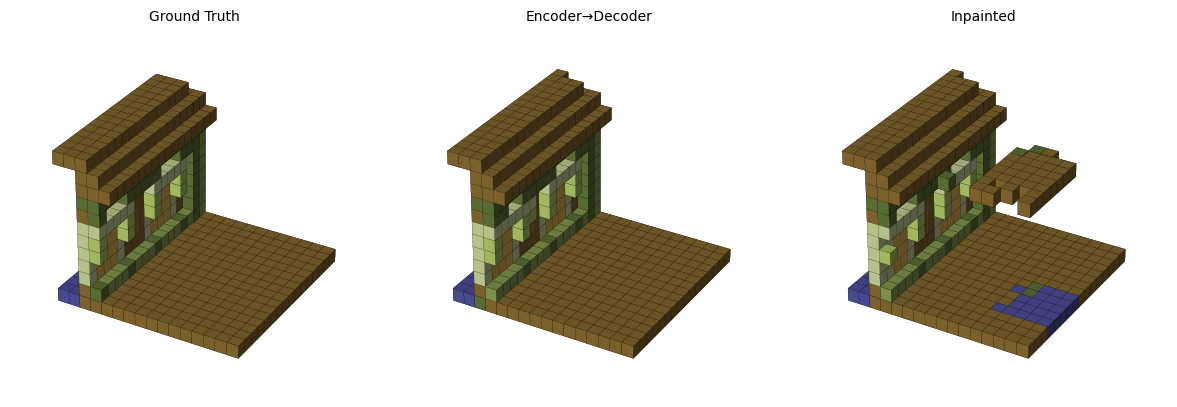

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 假设你的 model, diffusion, vae 都已加载
# model: trained diffusion UNet
# vae: trained VoxelVAE
# diffusion: GaussianDiffusion(timesteps=100, device=device)

# === 随机选择 patch 并嵌入 ===
paths = list(Path("dataset").rglob("patch_*.npy"))
chosen = np.random.choice(paths)
voxel = np.load(chosen)  # (16, 12, 16)

# === 编码为 latent ===
input_tensor = torch.tensor(voxel, dtype=torch.long).unsqueeze(0).to(device)
embed = vae.embedding(input_tensor).permute(0, 4, 1, 2, 3)
z, _, _ = vae.encoder(embed)

# === 制造 mask ===
corner_id = np.random.randint(0, 8)
mask = make_corner_mask(z.shape[1:], corner_id=corner_id).to(z.device)
diff_model = Small3DUNet(in_channels=64).to(device)
diff_model.load_state_dict(torch.load("diffusion_epoch10.pt", map_location=device))
diff_model.eval()
# === 反向 inpaint ===
with torch.no_grad():
    z_inpainted = latent_inpaint_blended(z, diff_model, diffusion, mask, steps=100)
    logits_orig = vae.decoder(z)
    logits_inpainted = vae.decoder(z_inpainted)
    recon_orig = logits_orig.argmax(1).squeeze(0).cpu().numpy()
    recon_inpainted = logits_inpainted.argmax(1).squeeze(0).cpu().numpy()

# === 可视化 ===
fig = plt.figure(figsize=(12, 4))
titles = ["Ground Truth", "Encoder→Decoder", "Inpainted"]
voxels = [voxel, recon_orig, recon_inpainted]

for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    visualize_voxel(ax, voxels[i], title=titles[i])

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\2770606941.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'), 

📥 Loaded model from voxelvae_64_434.pt


🌀 Inpainting Trials:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\2940739181.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecolors = plt.cm.get_cmap("tab20b", 31)(label % 31)
🌀 Inpainting Trials: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


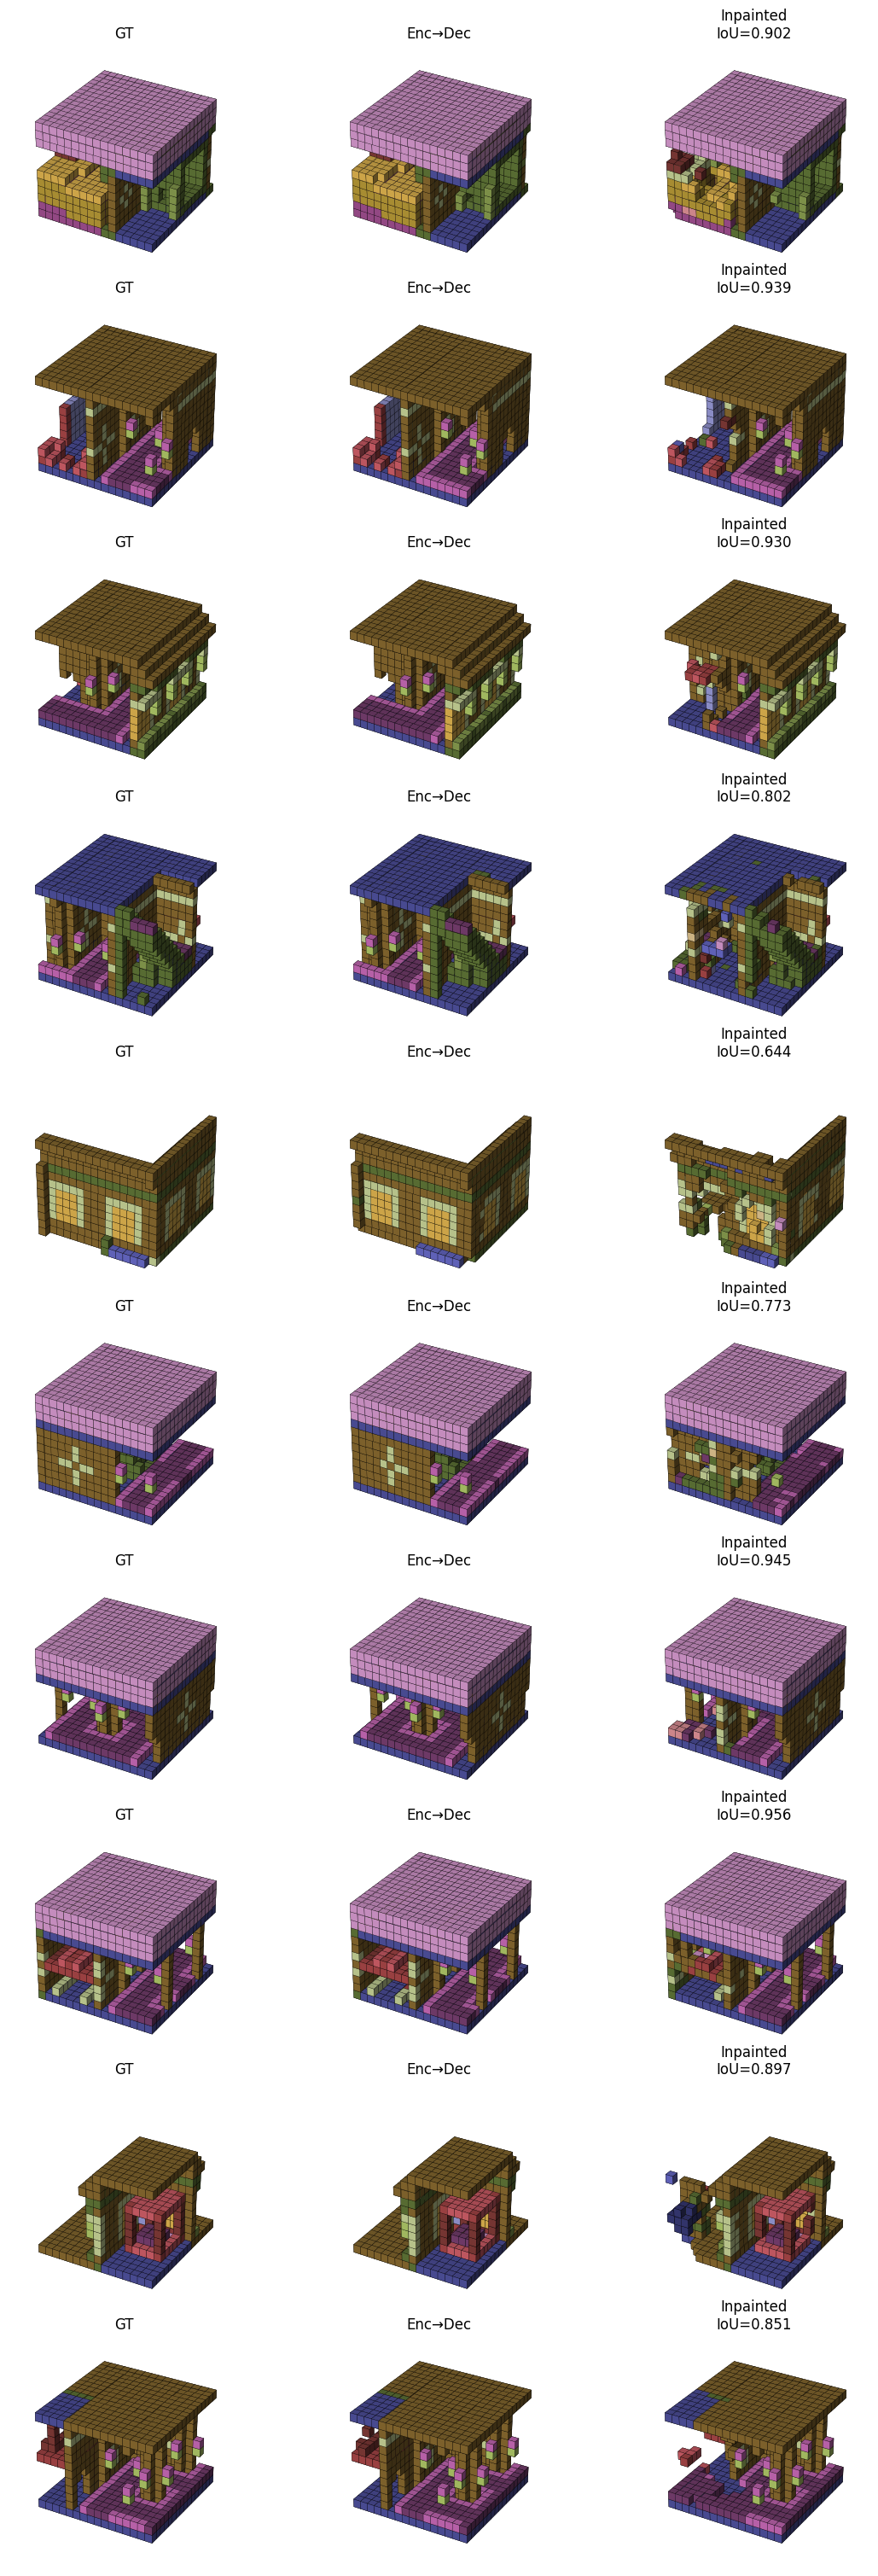

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# === 假设模型都已加载 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VoxelVAE().to(device)
vae.load("voxelvae_64_434.pt")
vae.eval()

diffusion = GaussianDiffusion(timesteps=100, device=device)

diff_model = Small3DUNet(in_channels=64).to(device)
diff_model.load_state_dict(torch.load("diffusion_epoch16.pt", map_location=device))
diff_model.eval()

# === Mask 工具 ===
def make_corner_mask(shape=(64, 4, 3, 4), corner_id=0):
    mask = torch.zeros(shape, dtype=torch.float32)
    d, h, w = shape[1], shape[2], shape[3]

    d_start = 0 if corner_id & 1 == 0 else d - 2
    h_start = 0 if (corner_id >> 1) & 1 == 0 else h - 2
    w_start = 0 if (corner_id >> 2) & 1 == 0 else w - 2

    mask[:, d_start:d_start+2, h_start:h_start+2, w_start:w_start+2] = 1.0
    return mask
# def make_corner_mask(shape=(64, 4, 3, 4), corner_id=0):
#     mask = torch.zeros(shape, dtype=torch.float32)
#     d, h, w = shape[1], shape[2], shape[3]

#     d_start = 0 if corner_id & 1 == 0 else d - 2
#     h_start = 0 if (corner_id >> 1) & 1 == 0 else h - 2
#     w_start = 0 if (corner_id >> 2) & 1 == 0 else w - 2

#     mask[:, d_start:d_start+2, h_start:h_start+2, w_start:w_start+2] = 1.0
#     return mask
# === 可视化 ===
def make_random_patch_mask(shape=(64, 4, 3, 4), patch_size=(64, 2, 1, 2)):
    """
    在给定 shape 空间中随机放置一个 patch_size 的 mask（值为 1）
    其他区域全为 0
    """
    assert all(p <= s for p, s in zip(patch_size, shape)), "Patch size must fit inside shape"

    D, H, W = shape[1], shape[2], shape[3]
    pD, pH, pW = patch_size[1], patch_size[2], patch_size[3]

    # === 随机起始坐标（不超界）
    d_start = np.random.randint(0, D - pD + 1)
    h_start = np.random.randint(0, H - pH + 1)
    w_start = np.random.randint(0, W - pW + 1)

    # === 构造 mask
    mask = torch.zeros(shape, dtype=torch.float32)
    mask[:, d_start:d_start + pD, h_start:h_start + pH, w_start:w_start + pW] = 1.0
    return mask
def make_keep_i_voxels_mask(shape=(64, 4, 3, 4), keep_i=1, seed=None):
    """
    保留 `keep_i` 个 (D, H, W) 空间位置，对应位置保留全部 64 维通道，其余为 1.0（遮挡），保留位置为 0.0（不遮挡）
    """
    C, D, H, W = shape
    if seed is not None:
        np.random.seed(seed)

    total_positions = D * H * W
    assert keep_i <= total_positions, "keep_i 超出位置数"

    # 随机选择保留的 voxel 空间位置
    all_indices = np.arange(total_positions)
    keep_indices = np.random.choice(all_indices, size=keep_i, replace=False)

    # 将 index 转为 (d, h, w)
    dhw_coords = np.unravel_index(keep_indices, (D, H, W))
    mask = torch.ones((C, D, H, W), dtype=torch.float32)

    for d, h, w in zip(*dhw_coords):
        mask[:, d, h, w] = 0.0  # 该位置的所有通道保留

    return mask

def visualize_voxel(ax, label, mask=None, title=""):
    """
    可视化 voxel patch，支持可选 mask 高亮（红色）。
    - label: numpy array, shape (16,12,16)
    - mask: optional binary mask (same shape)
    """
    label = np.transpose(label, (0, 2, 1))  # XZY
    mask = np.transpose(mask, (0, 2, 1)) if mask is not None else None
    filled = (label != 0)

    facecolors = plt.cm.get_cmap("tab20b", 31)(label % 31)
    if mask is not None:
        # 将被 mask 遮挡的位置标红 (RGBA)
        facecolors[mask] = [1.0, 0.0, 0.0, 1.0]  # 红色不透明

    facecolors[~filled] = [0, 0, 0, 0]  # 背景透明

    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')


# === 主流程 ===
paths = list(Path("dataset").rglob("patch_*.npy"))
N = 10  # 重复次数
cols = 3  # 每个样本显示 GT / Enc→Dec / Inpainted
rows = N
fig = plt.figure(figsize=(cols * 4, rows * 3))

ious = []

for rep in tqdm(range(N), desc="🌀 Inpainting Trials"):
    path = np.random.choice(paths)
    voxel = np.load(path)

    input_tensor = torch.tensor(voxel, dtype=torch.long).unsqueeze(0).to(device)
    embed = vae.embedding(input_tensor).permute(0, 4, 1, 2, 3)
    z, _, _ = vae.encoder(embed)

    # 保留 i 个 voxel，其余全部 mask 掉
    mask = make_keep_i_voxels_mask(shape=z.shape[1:], keep_i=24).to(z.device)
    mask = make_corner_mask(shape=z.shape[1:], corner_id=0).to(z.device)
    with torch.no_grad():
        z_inpainted = latent_inpaint_blended(z, diff_model, diffusion, mask, steps=100)
        logits_orig = vae.decoder(z)
        logits_inpainted = vae.decoder(z_inpainted)
        recon_orig = logits_orig.argmax(1).squeeze(0).cpu().numpy()
        recon_inpainted = logits_inpainted.argmax(1).squeeze(0).cpu().numpy()

    # === IOU
    valid_mask = np.logical_or(recon_orig != 0, recon_inpainted != 0)
    match_mask = (recon_orig == recon_inpainted) & valid_mask
    iou = match_mask.sum() / valid_mask.sum() if valid_mask.sum() > 0 else 0.0
    ious.append(iou)

    for i, (title, data) in enumerate([
        ("GT", voxel),
        ("Enc→Dec", recon_orig),
        ("Inpainted", recon_inpainted),
    ]):
        ax = fig.add_subplot(rows, cols, rep * cols + i + 1, projection='3d')
        visualize_voxel(ax, data, title=title if i != 2 else f"Inpainted\nIoU={iou:.3f}")

plt.tight_layout()
plt.subplots_adjust(top=0.99, hspace=0.1)
plt.show()


(16, 12, 1216)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9060\3189046795.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20b", 31)


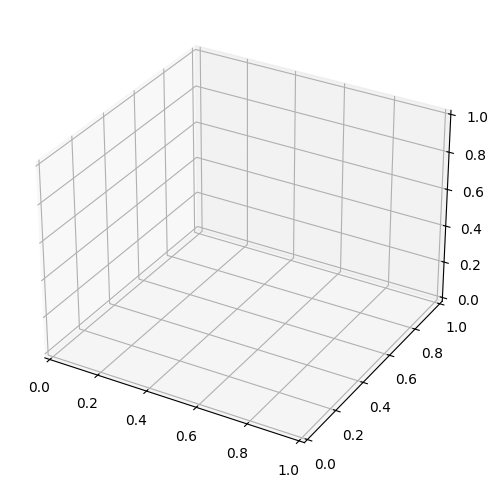

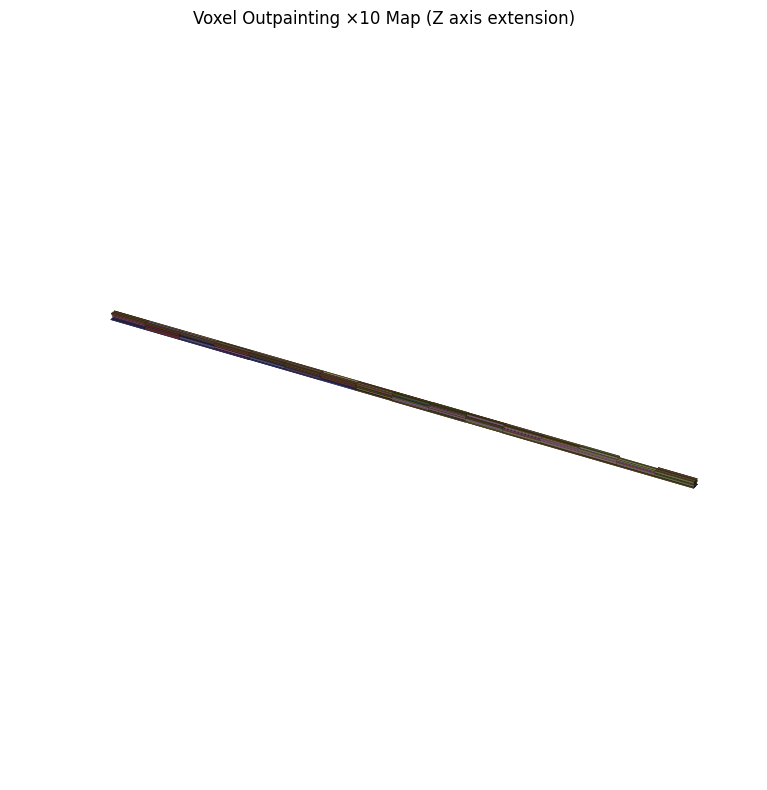

<Figure size 640x480 with 0 Axes>

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Assumed already loaded:
# vae, diff_model, diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.eval()
diff_model.eval()

# === 初始化 voxel patch
voxel = np.load(np.random.choice(list(Path("dataset").rglob("patch_*.npy"))))
input_tensor = torch.tensor(voxel, dtype=torch.long).unsqueeze(0).to(device)
embed = vae.embedding(input_tensor).permute(0, 4, 1, 2, 3)
z_start, _, _ = vae.encoder(embed)  # [1, 64, 4, 3, 4]

# === 先 decode 得到 label
with torch.no_grad():
    logits = vae.decoder(z_start)
    label = logits.argmax(1).squeeze(0).cpu().numpy()  # [16,12,16]

# === 初始化 outpaint latent
z_current = z_start.clone()

# === 重复 outpaint
for _ in range(100):
    with torch.no_grad():
        # decode → voxel label
        logits = vae.decoder(z_current)
        full_voxel = logits.argmax(1).squeeze(0).cpu().numpy()  # [16,12,D]

        # 提取最后 D/4 作为 known
        known_voxel = full_voxel[:, :, -4:]  # [16,12,4]
        input_tensor = torch.tensor(known_voxel, dtype=torch.long).unsqueeze(0).to(device)
        embed = vae.embedding(input_tensor).permute(0, 4, 1, 2, 3)
        z_known, _, _ = vae.encoder(embed)  # [1, 64, 4, 3, 4]

        # 构造空 latent，并放入 z_known 的右1/4
        z_base = torch.zeros((1, 64, 4, 3, 4), device=device)
        z_base[:, :, :, :, :1] = z_known[:, :, :, :, -1:]

        # mask 只保留右1/4
        mask = torch.zeros_like(z_base)
        mask[:, :, :, :, :1] = 1.0

        # inpaint 得到新的右3/4 latent
        z_inpainted = latent_inpaint_blended(z_base, diff_model, diffusion, mask)
        z_new = z_inpainted[:, :, :, :, 1:]  # [1, 64, 4, 3, 3]

        # 拼接到原始 latent
        z_current = torch.cat([z_current, z_new], dim=4)

# === 最终 decode → label
with torch.no_grad():
    logits = vae.decoder(z_current)
    final_label = logits.argmax(1).squeeze(0).cpu().numpy()  # [16,12,D']
print(final_label.shape)
# === 可视化函数
def visualize_voxel_long(label, block_size=16, title="Voxel Outpainting Map"):
    """
    横向拼接的 voxel map 可视化。
    - label: [X, Y, Z]，如 [16, 12, 136]
    - block_size: 每个 voxel patch 的 Z 尺寸（默认为 16）
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    label = np.transpose(label, (0, 2, 1))  # [X, Z, Y]
    X, Z, Y = label.shape
    filled = label != 0
    cmap = plt.cm.get_cmap("tab20b", 31)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]

    fig = plt.figure(figsize=(Z // 4, X // 2))  # 宽高根据 Z 决定
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.05)

    ax.set_title(title)
    ax.set_box_aspect([Z, X, Y])  # 自动拉伸
    ax.set_xlabel("Z axis")
    ax.set_ylabel("X axis")
    ax.set_zlabel("Y axis")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
# === 可视化拼接结果
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
visualize_voxel_long(final_label, block_size=16, title="Voxel Outpainting ×10 Map (Z axis extension)")

plt.tight_layout()
plt.show()


In [37]:
final_label.shape


(16, 12, 1216)

In [38]:
import csv
import numpy as np

# 假设 final_label 是你的 [16, 12, 136] voxel array
# label_to_name 是你提供的 label 映射表
label_to_name = [ 
    'minecraft:air', 'minecraft:birch_leaves', 'minecraft:birch_planks', 'minecraft:birch_stairs',
    'minecraft:black_wool', 'minecraft:bookshelf', 'minecraft:cobblestone', 'minecraft:cobblestone_stairs',
    'minecraft:cobblestone_wall', 'minecraft:dark_oak_fence', 'minecraft:dark_oak_leaves',
    'minecraft:dark_oak_log', 'minecraft:dark_oak_planks', 'minecraft:dark_oak_stairs', 'minecraft:dirt',
    'minecraft:glass_pane', 'minecraft:grass_block', 'minecraft:light_gray_wool', 'minecraft:oak_fence',
    'minecraft:oak_leaves', 'minecraft:oak_planks', 'minecraft:oak_slab', 'minecraft:oak_stairs',
    'minecraft:polished_andesite', 'minecraft:red_carpet', 'minecraft:smooth_stone_slab', 'minecraft:stone',
    'minecraft:torch', 'minecraft:white_carpet', 'minecraft:white_wool', 'minecraft:air'  # for unknown
]
cnt=0
# 输出路径
output_csv = "generated_voxel_map.csv"

# 写入 CSV
with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['x', 'y', 'z', 'block'])

    for x in range(final_label.shape[0]):
        for y in range(final_label.shape[1]):
            for z in range(final_label.shape[2]):
                label = int(final_label[x, y, z])
           # 跳过 air
                if label == 0:
                    cnt += 1
                block = label_to_name[label]
                writer.writerow([x, y, z, block])

print(f"✅ CSV saved to: {output_csv}")
print(cnt)

✅ CSV saved to: generated_voxel_map.csv
232388
